$\text{\large Motion Energy Across Age} \\ 
\text{\small Author: Stellina Ao (Churchland Lab)} \newline
\text{\small Date Created: 07/18/2025} \newline
\text{\small Last Edited: 07/24/2025} \newline
\text{\small Purpose: The purpose of this script is to confirm that the DLC model is reliable by replicating the observation that the } \newline \text{\small motion energy of older mice (18 months) is smaller than that of younger mice (3 months). }
$

In [62]:
# import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import awkward as ak
import scienceplots

from scipy.stats import zscore

from lib import constants

In [37]:
# pretty plots
plt.style.use(['science','nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [57]:
# import data and store in pd dataframe

bodyparts = ["ear_tip", "ear_base", "ear_bottom", "pupil", "nose_tip", "nose_corner", "tongue", "fr_paw", "fl_paw"]
subject_ids = ["MR15", "MR17", "MR19", "MR20", "MR26", "MR35", "MR47", "MR52"]
session_ids = ["20221006_125935", "20221006_160204", "20221212_113618", "20221212_152230", "20230425_130517", "20230808_124302", "20240408_125103", "20240408_145925"]
age_groups = ["3 months", "18 months"]
n_subj = len(subject_ids)
n_bodyparts = len(bodyparts)
model_name = "model1-lite"

def read_data(subject_id, session_id, bodyparts):
    df = pd.read_csv(f"Data/{model_name}/{subject_id}_DynamicForaging_{session_id}_cam0_00000000DLC_resnet50_MR15Jul8shuffle1_300000.csv", skiprows=[0, 2])

    for part in bodyparts:
        df.rename(columns={f"{part}": f"{part}_x", f"{part}.1": f"{part}_y", f"{part}.2": f"{part}_p"}, inplace=True)

    return df

In [4]:
dlc_outputs = []
for subj_id, sess_id in zip(subject_ids, session_ids):
    dlc_outputs.append(read_data(subj_id, sess_id, bodyparts))

In [5]:
norm_dict = {}

for part in bodyparts:
    x = f"{part}_x"; y = f"{part}_y"
    part_x_all = pd.concat([dlc_output[x] for dlc_output in dlc_outputs])
    part_y_all = pd.concat([dlc_output[y] for dlc_output in dlc_outputs])
    
    part_x_mean = np.mean(part_x_all)
    part_y_mean = np.mean(part_y_all)
    part_x_std = np.std(part_x_all)
    part_y_std = np.std(part_y_all)

    norm_dict.update({f"{x}_mean": part_x_mean, f"{x}_std": part_x_std, f"{y}_mean": part_y_mean, f"{y}_std": part_y_std})

In [6]:
df = dlc_outputs[0]
part = 'ear_tip'

x = f"{part}_x"; y = f"{part}_y"; p = f"{part}_p"
coords = df[[x, y]]
print(len(coords))
coords = coords.loc[df.index[df[p] >= 0].tolist()]# indices where df[f"{part}_p"] is greater than some threshold a
print(len(coords))

79992
79992


In [161]:
len(coords)

79992

In [59]:
# function to return the array of average motion energy for all body parts in a video
def all_avg_me(df, bodyparts, thresh=0, doNorm=False, normParams=None, doNormXY=False):
    mes = np.zeros(len(bodyparts))
    for i, part in enumerate(bodyparts):
        mes[i] = avg_me(df, part, thresh, doNorm, normParams, doNormXY)
    return mes

# function to return the matrix of motion energy for all body parts in a video
def all_me(df, bodyparts, thresh=0, doNorm=False, normParams=None, doNormXY=False, doNormBP=False):
    mes = [zscore(motionEnergy(df, part, thresh, doNorm, normParams, doNormXY)) if doNormBP else motionEnergy(df, part, thresh, doNorm, normParams, doNormXY) for part in bodyparts]
    return ak.Array(mes) # jagged array, awkward array data type

# function to calculate average motion energy for a given body part
def avg_me(df, part, thresh=0, doNorm=False, normParams=None, doNormXY=False):
    return np.mean(motionEnergy(df, part, thresh, doNorm, normParams, doNormXY))

# function to calculate motion energy array of a body part
def motionEnergy(df, part, thresh=0, doNorm=False, normParams=None, doNormXY=False):
    x = f"{part}_x"; y = f"{part}_y"; p = f"{part}_p"
    coords = df[[x, y]]
    coords = coords.loc[df.index[df[p] >= thresh].tolist()] # indices where df[f"{part}_p"] is greater than some threshold a

    if doNorm and normParams != None: 
        coords[x] = (coords[x]-normParams[f"{x}_mean"])/normParams[f"{x}_std"]
        coords[y] = (coords[y]-normParams[f"{y}_mean"])/normParams[f"{y}_std"]
    elif doNorm:
        coords[x] = (coords[x]-coords[x].mean())/coords[y].std()
        coords[y] = (coords[y]-coords[y].mean())/coords[y].std()
    elif doNormXY:
        coords = (coords-coords.mean())/coords.std()
    me = [np.sqrt((coords[x].iloc[i+1]-coords[x].iloc[i])**2 + (coords[y].iloc[i+1]-coords[y].iloc[i])**2) for i in range(len(coords)-1)]

    return me

## Motion Energy, Different Normalization Techniques

### Motion Energy, No Thresh, Normalize Per Body Part and Animal, Across X & Y

In [8]:
doNormXY = True

avg_mes_nothresh_xy = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_nothresh_xy[i] = all_avg_me(dlc_output, bodyparts, doNormXY=doNormXY)

0
1
2
3
4
5
6
7


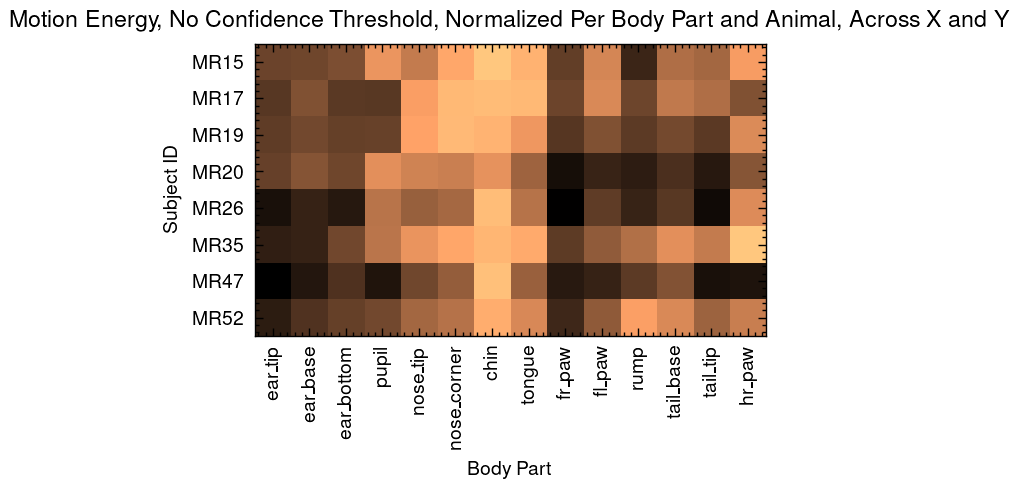

In [ ]:
title = "Motion Energy, No Confidence Threshold, Normalized Per Body Part and Animal, Across X and Y"

fig, ax = plt.subplots()
ax.imshow(avg_mes_nothresh_xy, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/1-across_xy/{model_name}/motionEnergy_noConfThresh_normAcrossXY-heatmap.png")
plt.show()

In [51]:
avg_me_3mt_nothresh_xy = [np.mean(avg_mes_nothresh_xy[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_nothresh_xy = [np.mean(avg_mes_nothresh_xy[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_nothresh_xy = [np.std(avg_mes_nothresh_xy[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_nothresh_xy = [np.std(avg_mes_nothresh_xy[4:,i]) for i in range(len(bodyparts))]

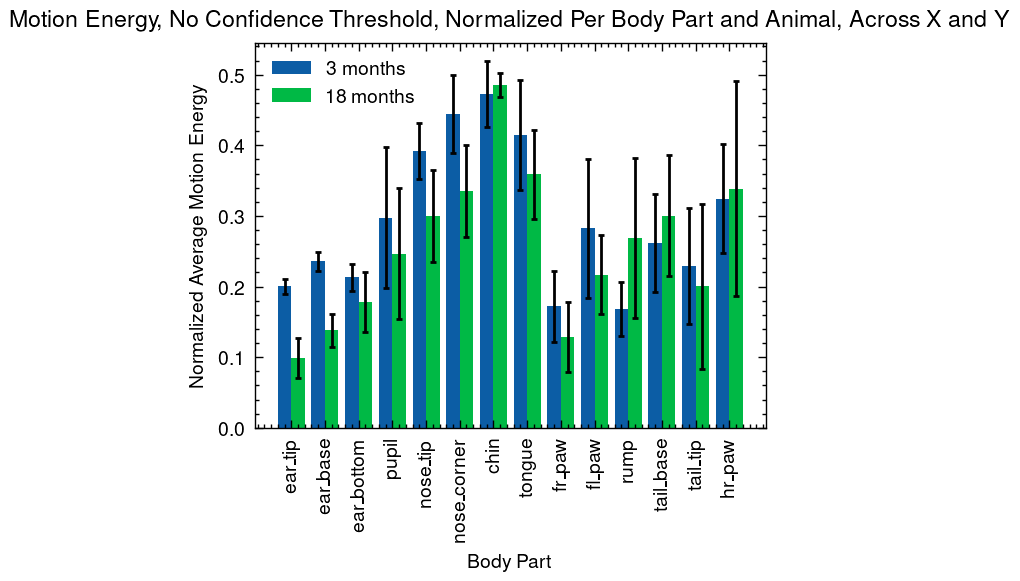

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_nothresh_xy, yerr=std_me_3mt_nothresh_xy, width=0.4, capsize=1, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_nothresh_xy, yerr=std_me_18mt_nothresh_xy, width=0.4, capsize=1, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/1-across_xy/{model_name}/motionEnergy_noConfThresh_normAcrossXY-barplot.png")
plt.show()

### Motion Energy, Thresh 0.6, Normalize Per Body Part and Animal, Across X & Y

In [ ]:
doNormXY=True
thresh = 0.6
avg_mes_thresh_xy = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_thresh_xy[i] = all_avg_me(dlc_output, bodyparts, thresh, doNormXY=doNormXY)

0
1
2
3
4
5
6
7


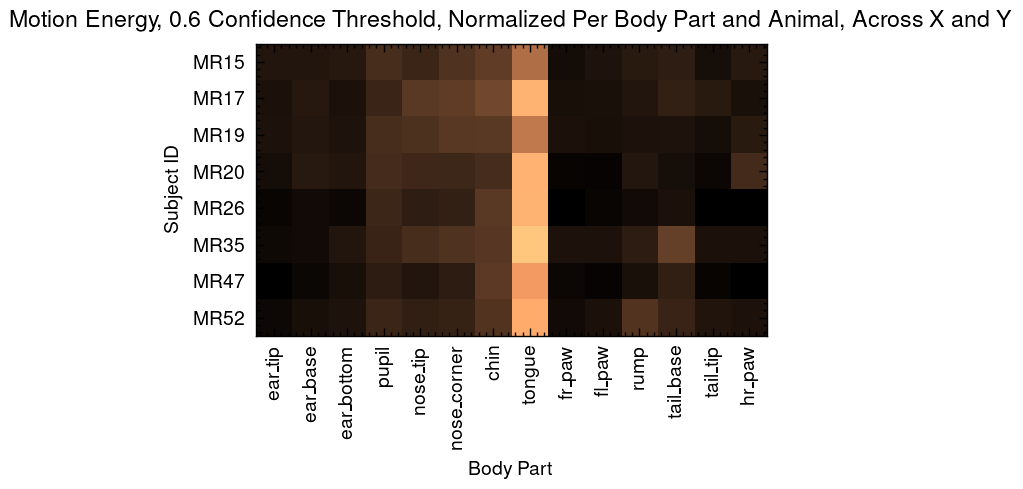

In [ ]:
title = "Motion Energy, 0.6 Confidence Threshold, Normalized Per Body Part and Animal, Across X and Y"

fig, ax = plt.subplots()
ax.imshow(avg_mes_thresh_xy, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/1-across_xy/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_normAcrossXY-heatmap.png")
plt.show()

In [106]:
avg_me_3mt_thresh_xy = [np.mean(avg_mes_thresh_xy[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_thresh_xy = [np.mean(avg_mes_thresh_xy[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_thresh_xy = [np.std(avg_mes_thresh_xy[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_thresh_xy = [np.std(avg_mes_thresh_xy[4:,i]) for i in range(len(bodyparts))]

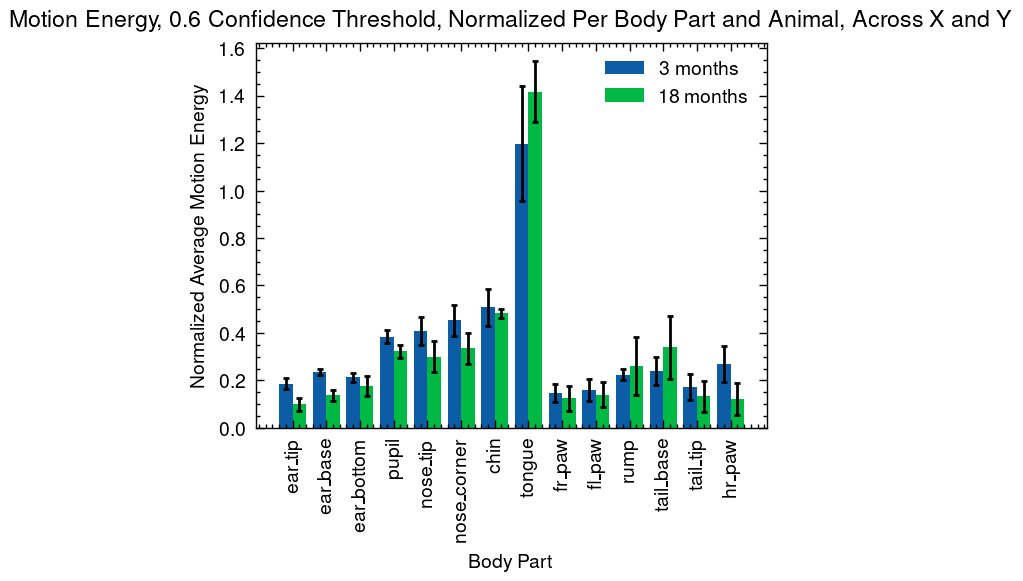

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_thresh_xy, yerr=std_me_3mt_thresh_xy, width=0.4, capsize=1, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_thresh_xy, yerr=std_me_18mt_thresh_xy, width=0.4, capsize=1, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
plt.savefig(f"figs/motion_energy/1-across_xy/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_normAcrossXY-barplot.png")
plt.show()

### Motion Energy, No Thresh, Normalize Per Animal Per Body Part 

In [47]:
doNorm=True
avg_mes_nothresh_norm_peranimal = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_nothresh_norm_peranimal[i] = all_avg_me(dlc_output, bodyparts, doNorm=doNorm)

0
1
2
3
4
5
6
7


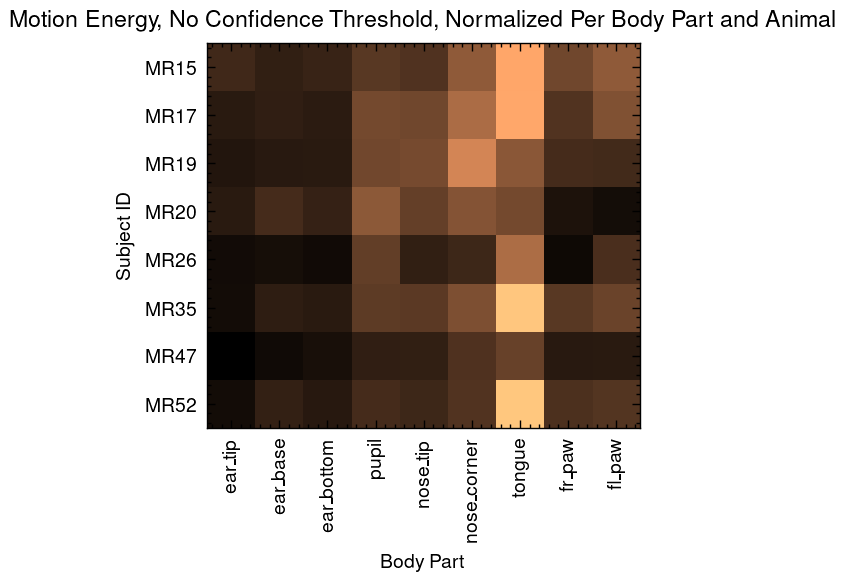

In [76]:
title = "Motion Energy, No Confidence Threshold, Normalized Per Body Part and Animal"

fig, ax = plt.subplots()
ax.imshow(avg_mes_nothresh_norm_peranimal, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/2-per_bp_animal/{model_name}/motionEnergy_noConfThresh_normPerBPAnimal-heatmap.png")
plt.show()

In [49]:
avg_me_3mt_nothresh_norm_peranimal = [np.mean(avg_mes_nothresh_norm_peranimal[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_nothresh_norm_peranimal = [np.mean(avg_mes_nothresh_norm_peranimal[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_nothresh_norm_peranimal = [np.std(avg_mes_nothresh_norm_peranimal[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_nothresh_norm_peranimal = [np.std(avg_mes_nothresh_norm_peranimal[4:,i]) for i in range(len(bodyparts))]

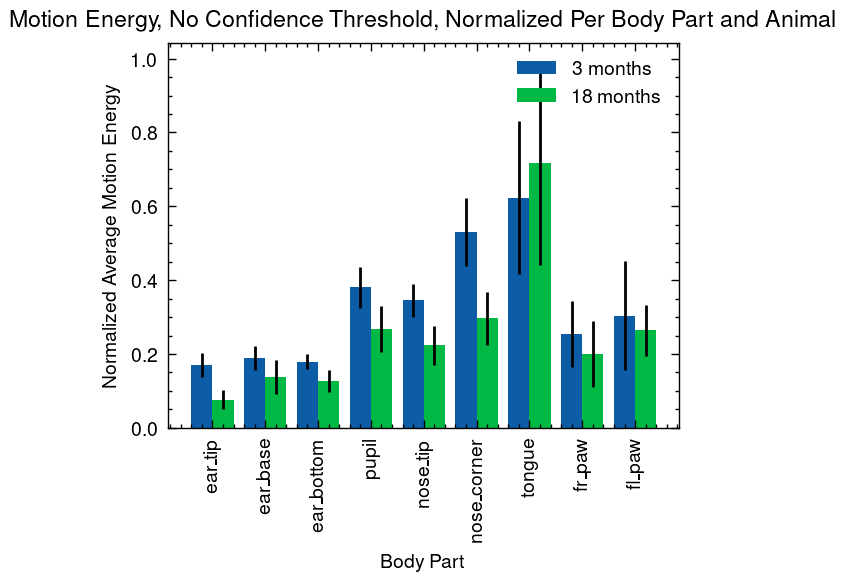

In [78]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_nothresh_norm_peranimal, yerr=std_me_3mt_nothresh_norm_peranimal, width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_nothresh_norm_peranimal, yerr=std_me_18mt_nothresh_norm_peranimal, width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
plt.savefig(f"figs/motion_energy/2-per_bp_animal/{model_name}/motionEnergy_noConfThresh_normPerBPAnimal-barplot.png")
plt.show()

### Motion Energy, Thresh 0.6, Normalize Per Animal Per Body Part

In [51]:
doNorm=True
thresh = 0.6
avg_mes_thresh_norm_peranimal = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_thresh_norm_peranimal[i] = all_avg_me(dlc_output, bodyparts, thresh, doNorm)

0
1
2
3
4
5
6
7


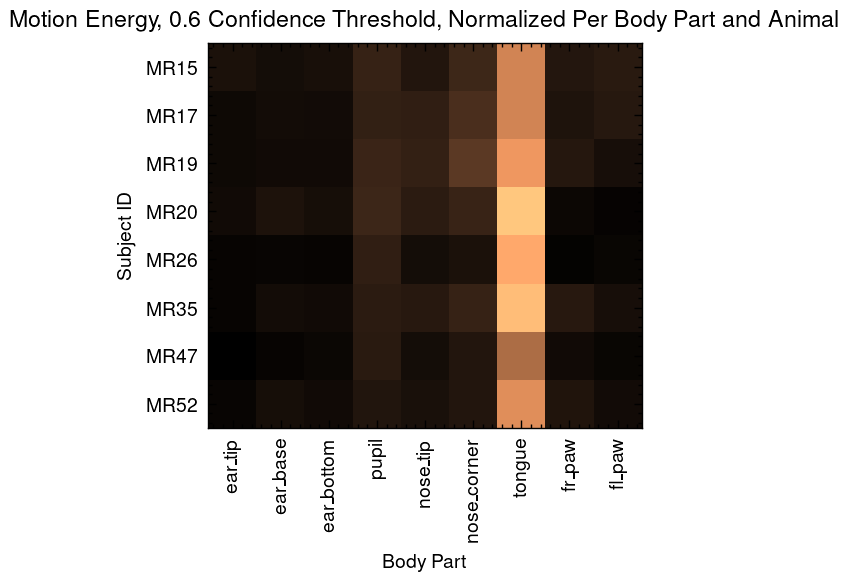

In [52]:
title = "Motion Energy, 0.6 Confidence Threshold, Normalized Per Body Part and Animal"

fig, ax = plt.subplots()
ax.imshow(avg_mes_thresh_norm_peranimal, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/2-per_bp_animal/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_normPerBPAnimal-heatmap.png")
plt.show()

In [53]:
avg_me_3mt_thresh_norm_peranimal = [np.mean(avg_mes_thresh_norm_peranimal[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_thresh_norm_peranimal = [np.mean(avg_mes_thresh_norm_peranimal[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_thresh_norm_peranimal = [np.std(avg_mes_thresh_norm_peranimal[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_thresh_norm_peranimal = [np.std(avg_mes_thresh_norm_peranimal[4:,i]) for i in range(len(bodyparts))]

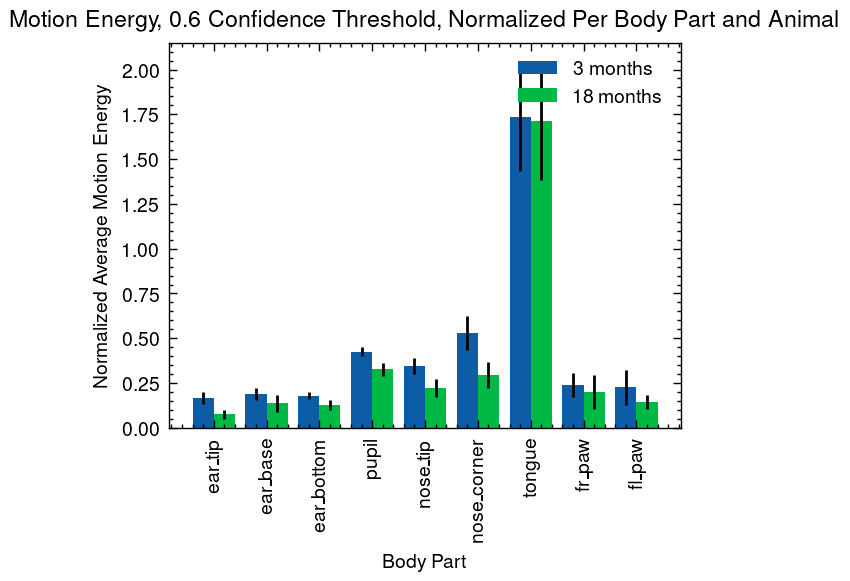

In [54]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_thresh_norm_peranimal, yerr=std_me_3mt_thresh_norm_peranimal, width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_thresh_norm_peranimal, yerr=std_me_18mt_thresh_norm_peranimal, width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
plt.savefig(f"figs/motion_energy/2-per_bp_animal/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_normPerBPAnimal-barplot.png")
plt.show()

### Motion Energy, No Thresh, Normalize Across Animals Per Body Part 

In [55]:
doNorm=True
avg_mes_nothresh_norm_all = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_nothresh_norm_all[i] = all_avg_me(dlc_output, bodyparts, doNorm=doNorm, normParams=norm_dict)

0
1
2
3
4
5
6
7


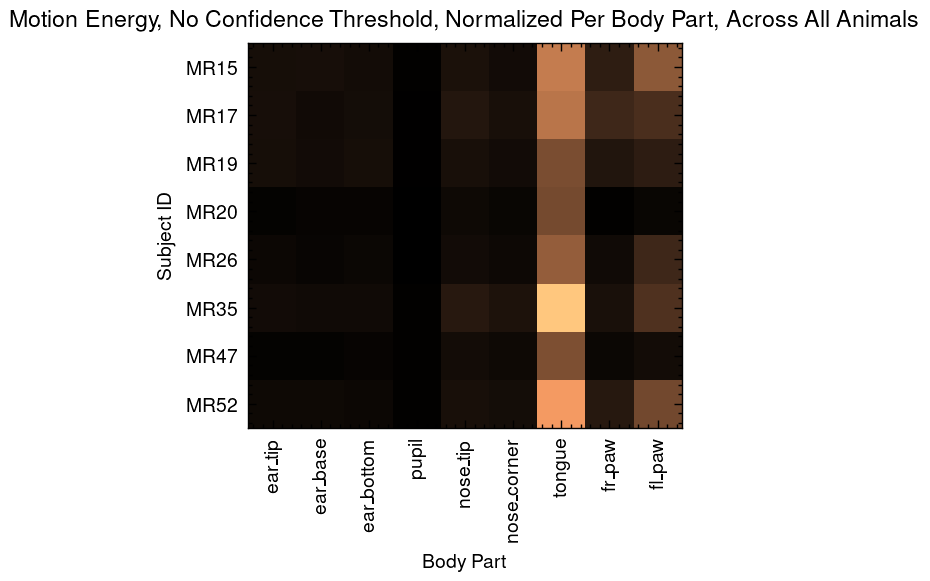

In [73]:
title = "Motion Energy, No Confidence Threshold, Normalized Per Body Part, Across All Animals"

fig, ax = plt.subplots()
ax.imshow(avg_mes_nothresh_norm_all, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/3-across_animals/{model_name}/motionEnergy_noConfThresh_normAcrossAnimals-heatmap.png")
plt.show()

In [74]:
avg_me_3mt_nothresh_norm_all = [np.mean(avg_mes_nothresh_norm_all[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_nothresh_norm_all = [np.mean(avg_mes_nothresh_norm_all[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_nothresh_norm_all = [np.std(avg_mes_nothresh_norm_all[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_nothresh_norm_all = [np.std(avg_mes_nothresh_norm_all[4:,i]) for i in range(len(bodyparts))]

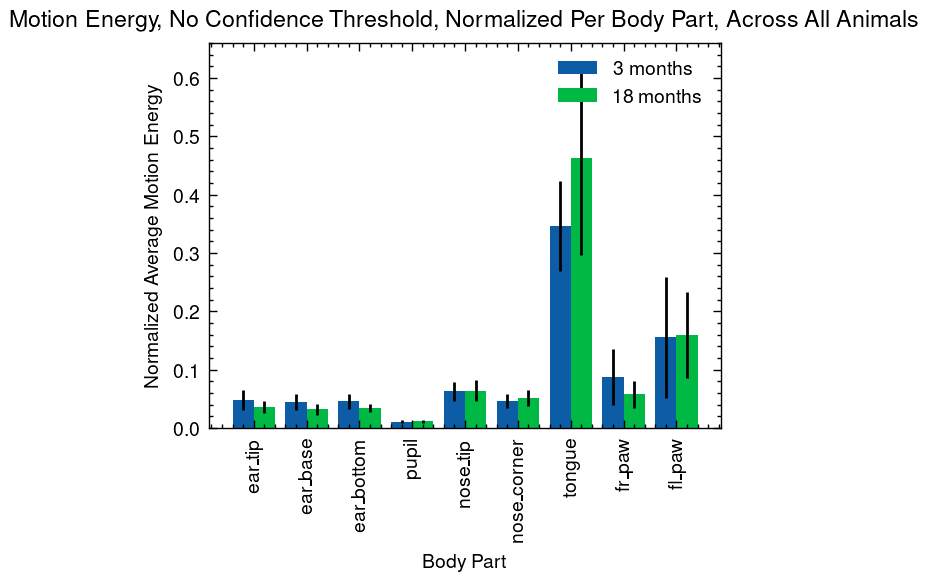

In [75]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_nothresh_norm_all, yerr=std_me_3mt_nothresh_norm_all, width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_nothresh_norm_all, yerr=std_me_18mt_nothresh_norm_all, width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
plt.savefig(f"figs/motion_energy/3-across_animals/{model_name}/motionEnergy_noConfThresh_normAcrossAnimals-barplot.png")
plt.show()

### Motion Energy, Thresh 0.6, Normalize Across Animals Per Body Part 

In [59]:
doNorm=True
thresh = 0.6
avg_mes_thresh_norm_all = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_thresh_norm_all[i] = all_avg_me(dlc_output, bodyparts, thresh, doNorm, normParams=norm_dict)

0
1
2
3
4
5
6
7


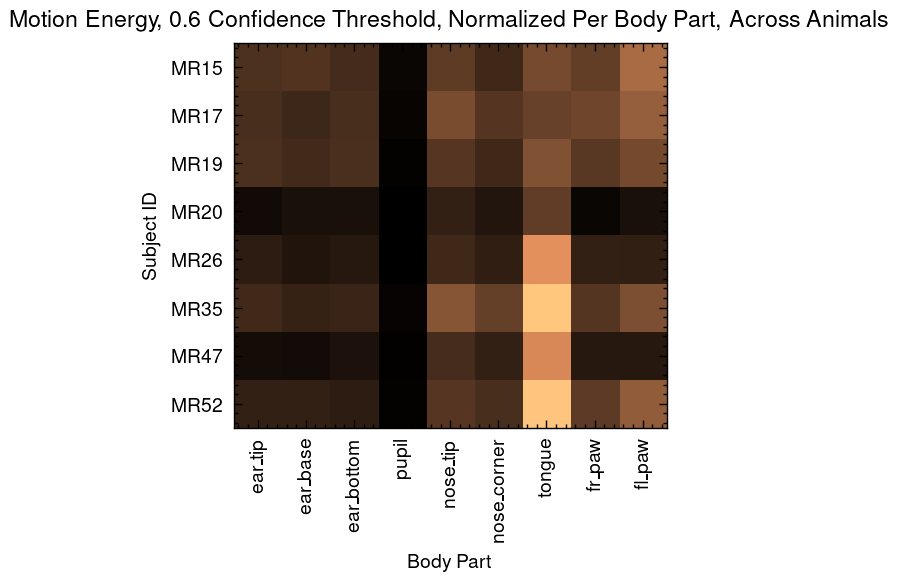

In [71]:
title = "Motion Energy, 0.6 Confidence Threshold, Normalized Per Body Part, Across Animals"

fig, ax = plt.subplots()
ax.imshow(avg_mes_thresh_norm_all, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/3-across_animals/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_normAcrossAnimals-heatmap.png")
plt.show()

In [69]:
avg_me_3mt_thresh_norm_all = [np.mean(avg_mes_thresh_norm_all[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_thresh_norm_all = [np.mean(avg_mes_thresh_norm_all[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_thresh_norm_all = [np.std(avg_mes_thresh_norm_all[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_thresh_norm_all = [np.std(avg_mes_thresh_norm_all[4:,i]) for i in range(len(bodyparts))]

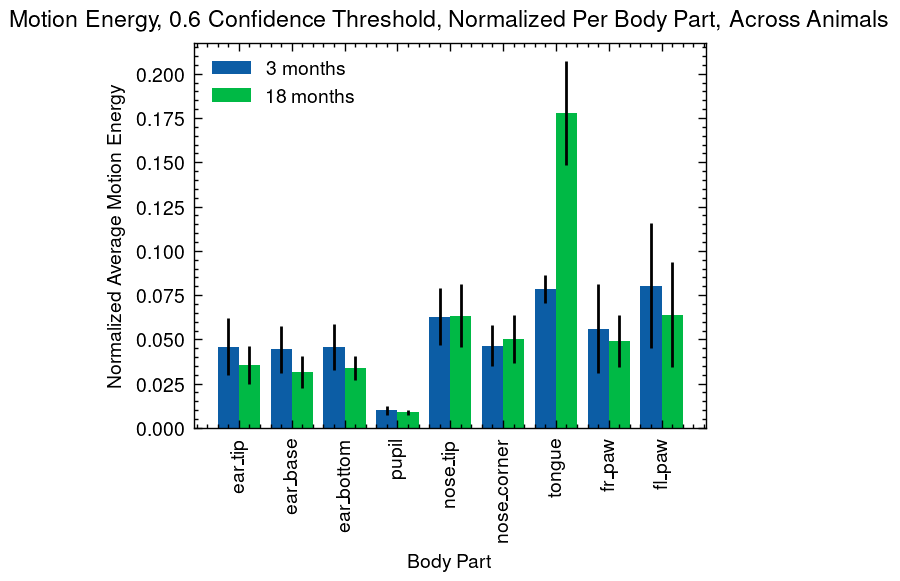

In [72]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_thresh_norm_all, yerr=std_me_3mt_thresh_norm_all, width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_thresh_norm_all, yerr=std_me_18mt_thresh_norm_all, width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
plt.savefig(f"figs/motion_energy/3-across_animals/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_normAcrossAnimals-barplot.png")
plt.show()

### Motion Energy, No Thresh, No Norm

In [79]:
avg_mes_nonorm_nothresh = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_nonorm_nothresh[i] = all_avg_me(dlc_output, bodyparts)

0
1
2
3
4
5
6
7


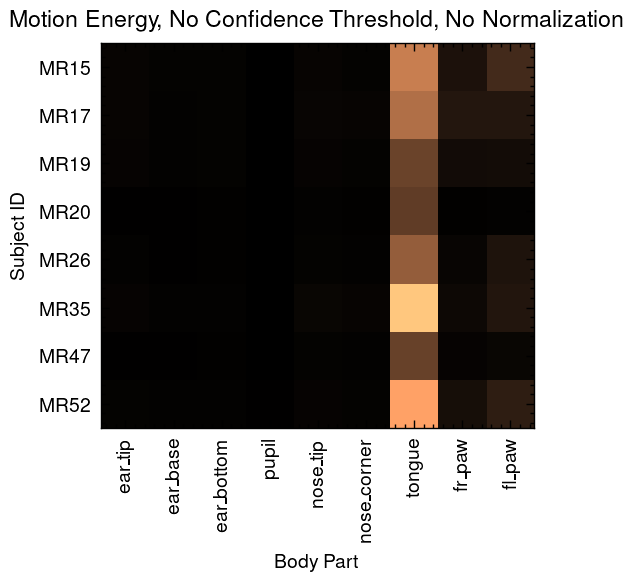

In [80]:
title = "Motion Energy, No Confidence Threshold, No Normalization"

fig, ax = plt.subplots()
ax.imshow(avg_mes_nonorm_nothresh, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/4-none/{model_name}/motionEnergy_noConfThresh_noNorm-heatmap.png")
plt.show()

In [81]:
avg_me_3mt_nonorm_nothresh = [np.mean(avg_mes_nonorm_nothresh[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_nonorm_nothresh = [np.mean(avg_mes_nonorm_nothresh[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_nonorm_nothresh = [np.std(avg_mes_nonorm_nothresh[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_nonorm_nothresh = [np.std(avg_mes_nonorm_nothresh[4:,i]) for i in range(len(bodyparts))]

In [132]:
len(np.arange(len(bodyparts)-1)-0.2)

8

In [131]:
len(avg_me_3mt_nonorm_nothresh[:6]+avg_me_3mt_nonorm_nothresh[7:])

8

In [ ]:
bodyparts = []

8

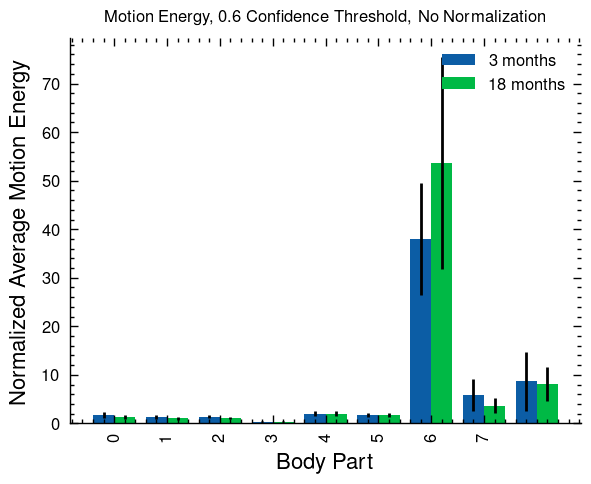

In [137]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_nonorm_nothresh, yerr=std_me_3mt_nonorm_nothresh, width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_nonorm_nothresh, yerr=std_me_18mt_nonorm_nothresh, width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)-1), bodyparts.remove("tongue"))
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
# plt.savefig(f"figs/motion_energy/4-none/{model_name}/motionEnergy_noConfThresh_noNorm-barplot.png")
plt.show()

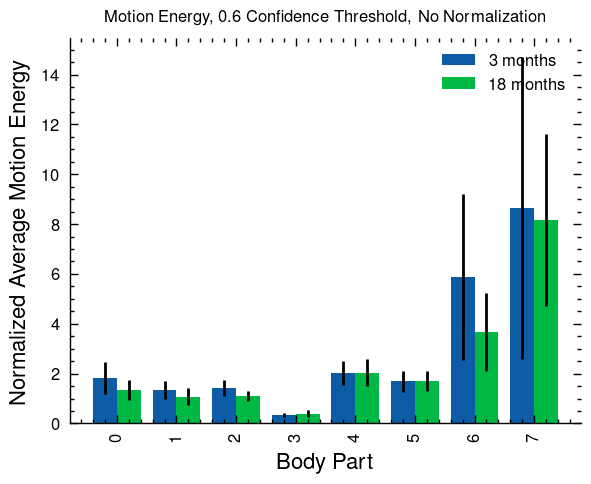

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts)-1)-0.2, avg_me_3mt_nonorm_nothresh[:6]+avg_me_3mt_nonorm_nothresh[7:], yerr=std_me_3mt_nonorm_nothresh[:6]+std_me_3mt_nonorm_nothresh[7:], width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts)-1)+0.2, avg_me_18mt_nonorm_nothresh[:6]+avg_me_18mt_nonorm_nothresh[7:], yerr=std_me_18mt_nonorm_nothresh[:6]+std_me_18mt_nonorm_nothresh[7:], width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)-1), bodyparts.remove("tongue"))
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
# plt.savefig(f"figs/motion_energy/4-none/{model_name}/motionEnergy_noConfThresh_noNorm-barplot.png")
plt.show()

### Motion Energy of Frames, Thresh 0.6, No Norm

In [83]:
thresh = 0.6
avg_mes_nonorm_thresh = np.zeros((len(dlc_outputs), len(bodyparts)))

for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    avg_mes_nonorm_thresh[i] = all_avg_me(dlc_output, bodyparts, thresh)

0
1
2
3
4
5
6
7


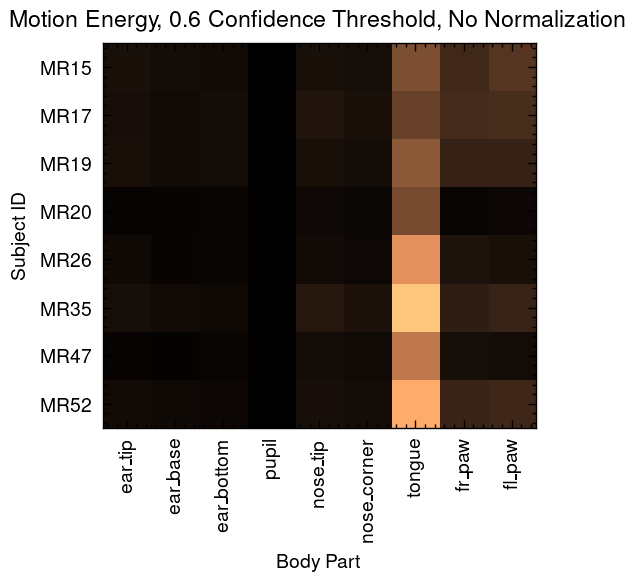

In [84]:
title = "Motion Energy, 0.6 Confidence Threshold, No Normalization"

fig, ax = plt.subplots()
ax.imshow(avg_mes_nonorm_thresh, cmap="copper")
ax.set_xticks(np.arange(len(bodyparts)), bodyparts, rotation='vertical')
ax.set_yticks(np.arange(len(subject_ids)), subject_ids)
ax.set_xlabel("Body Part"); ax.set_ylabel("Subject ID")
ax.set_title(title, wrap=True)
plt.savefig(f"figs/motion_energy/4-none/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_noNorm-heatmap.png")
plt.show()

In [85]:
avg_me_3mt_nonorm_thresh = [np.mean(avg_mes_nonorm_thresh[:4,i]) for i in range(len(bodyparts))]
avg_me_18mt_nonorm_thresh = [np.mean(avg_mes_nonorm_thresh[4:,i]) for i in range(len(bodyparts))]

std_me_3mt_nonorm_thresh = [np.std(avg_mes_nonorm_thresh[:4,i]) for i in range(len(bodyparts))]
std_me_18mt_nonorm_thresh = [np.std(avg_mes_nonorm_thresh[4:,i]) for i in range(len(bodyparts))]

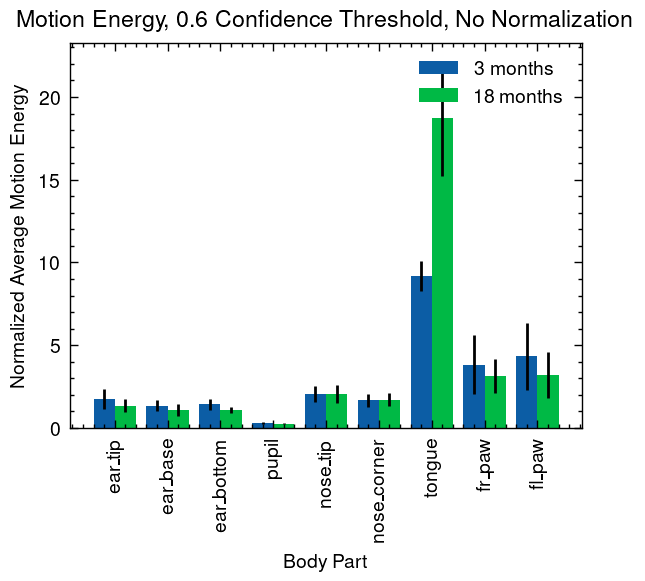

In [86]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(bodyparts))-0.2, avg_me_3mt_nonorm_thresh, yerr=std_me_3mt_nonorm_thresh, width=0.4, label="3 months")
ax.bar(np.arange(len(bodyparts))+0.2, avg_me_18mt_nonorm_thresh, yerr=std_me_18mt_nonorm_thresh, width=0.4, label="18 months")
ax.tick_params('x', rotation=90)
ax.set_xticks(np.arange(len(bodyparts)), bodyparts)
ax.legend()
ax.set_xlabel("Body Part"); ax.set_ylabel("Normalized Average Motion Energy")
ax.set_title(title)
plt.savefig(f"figs/motion_energy/4-none/{model_name}/motionEnergy_{int(thresh*100)}ConfThresh_noNorm-barplot.png")
plt.show()

## Quantify Proportion of Frames Filtered Out 

In [118]:
threshes = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

p_filtered = np.zeros((n_subj, n_bodyparts, len(threshes)))

for i, df in enumerate(dlc_outputs):
    for j, part in enumerate(bodyparts):
        for k, thresh in enumerate(threshes):
            p_filtered[i][j][k] = len(df.index[df[f"{part}_p"] < thresh])/len(df)

In [117]:
i = j = k = 0
df = dlc_outputs[0]
len(df.index[df[f"{part}_p"] > thresh])

62785

In [103]:
help(plt.colorbar)

Help on function colorbar in module matplotlib.pyplot:

colorbar(
    mappable: 'ScalarMappable | ColorizingArtist | None' = None,
    cax: 'matplotlib.axes.Axes | None' = None,
    ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None,
    **kwargs
) -> 'Colorbar'
    Add a colorbar to a plot.

    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
        `.ContourSet`, etc.) described by this colorbar.  This argument is
        mandatory for the `.Figure.colorbar` method but optional for the
        `.pyplot.colorbar` function, which sets the default to the current
        image.

        Note that one can create a `.ScalarMappable` "on-the-fly" to
        generate colorbars not attached to a previously drawn artist, e.g.
        ::

            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

    cax : `~matplotlib.axes.Axes`, optional
        Axes into which the colorbar will be drawn.  If `None`,

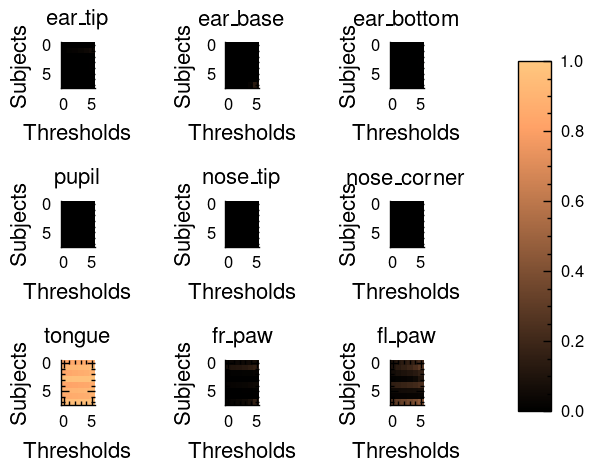

In [120]:
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(p_filtered[:,i,:], cmap='copper', vmin=0, vmax=1)
    ax.set_xlabel("Thresholds"); ax.set_ylabel("Subjects")
    ax.set_title(f"{bodyparts[i]}")
    ax.title.set_fontsize(constants.SMALL_SIZE)

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

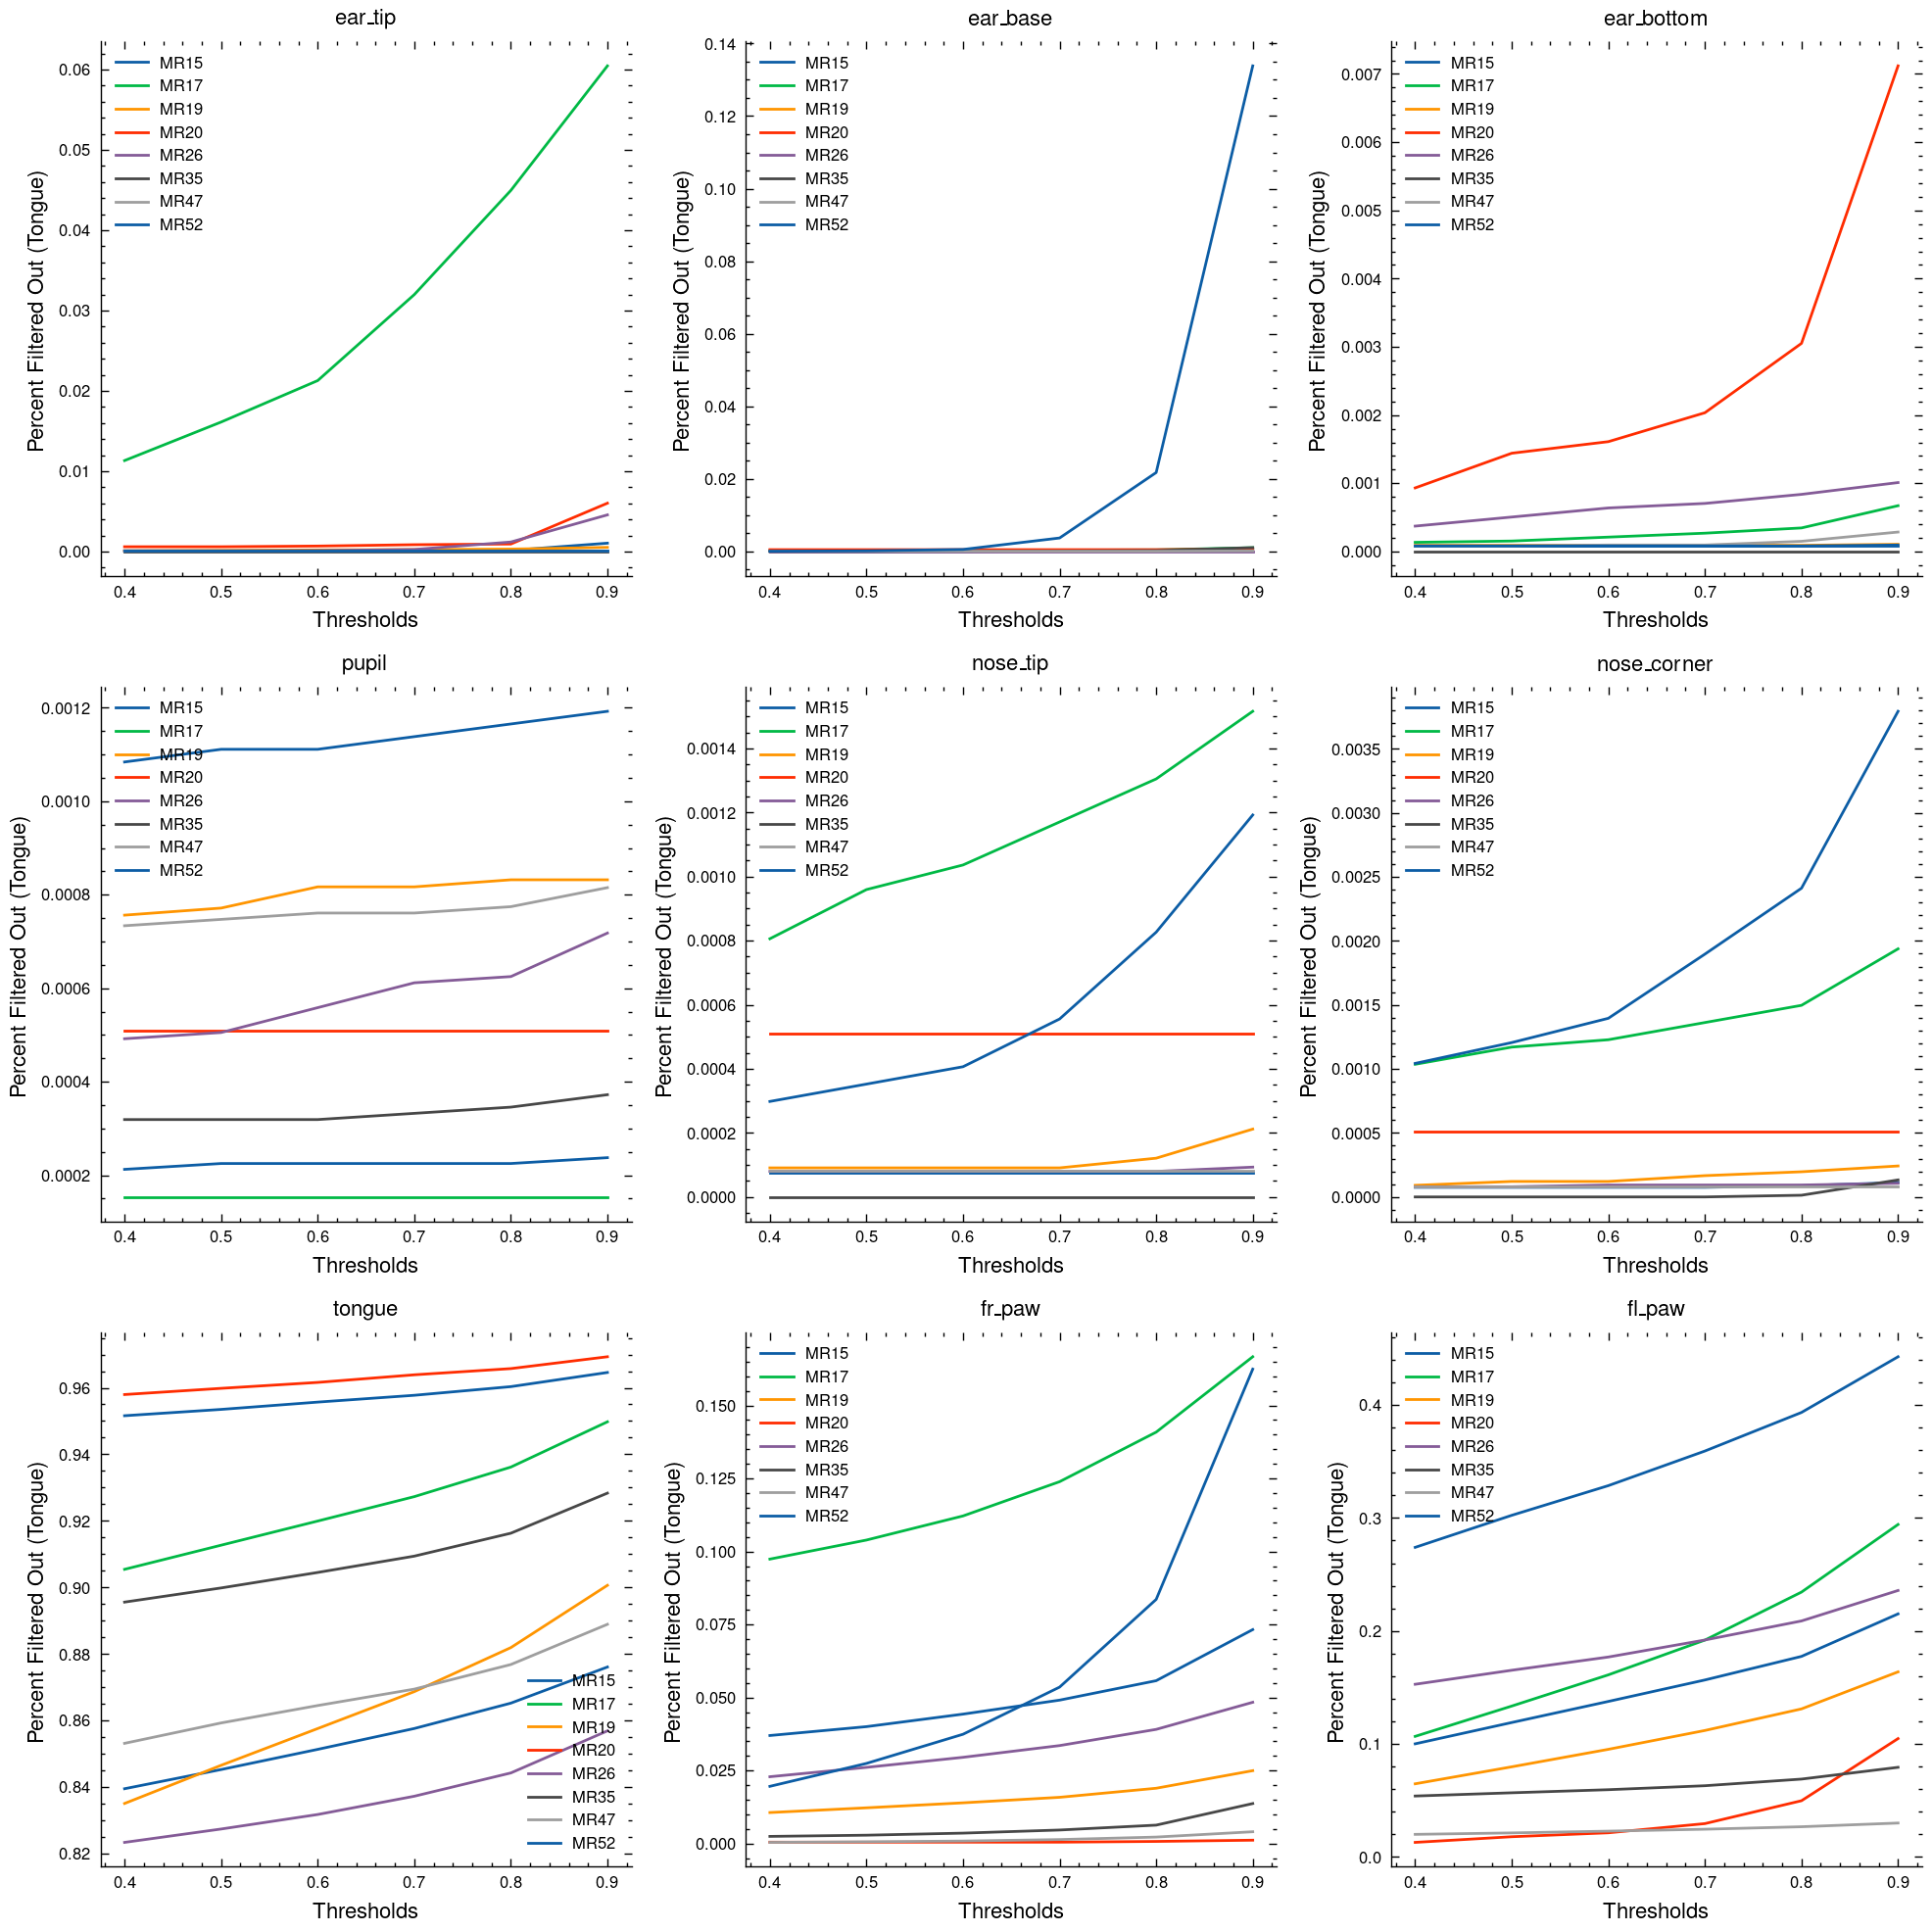

In [124]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for part_i, ax in enumerate(axes.flat):
    for subj_i in range(n_subj):
        ax.plot(threshes, p_filtered[subj_i, part_i], label=f"{subject_ids[subj_i]}")
    ax.set_xlabel("Thresholds"); ax.set_ylabel("Percent Filtered Out (Tongue)")
    ax.set_title(f"{bodyparts[part_i]}")
    ax.title.set_fontsize(constants.SMALL_SIZE)
    ax.legend()

fig.tight_layout()

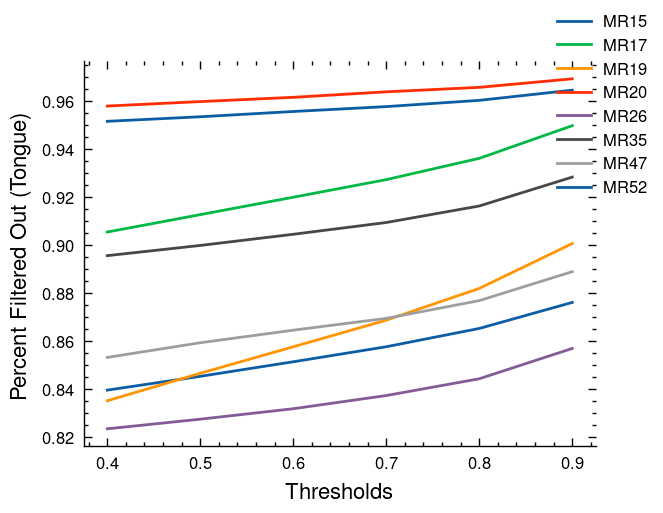

In [ ]:
part_idx = 6

fig, ax = plt.subplots()
for i in range(n_subj):
    ax.plot(threshes, p_filtered[i, part_idx], label=f"{subject_ids[i]}")
    ax.set_xlabel("Thresholds"); ax.set_ylabel("Percent Filtered Out (Tongue)")
fig.legend()

## Quantify % of Outlier Movements

In [ ]:
# grab the motion energy arrays for each animal and plot the distribution
# for each, get the percent of points above the 80% threshold
# either normalize within a body part or dont after step 2
# definitely don't normalize across animals

In [25]:
def p_me(mes, l_thresh=-np.inf, h_thresh=np.inf):
    total_count = len(mes)
    range_count = len([me for me in mes if me >= l_thresh and me <= h_thresh])

    return range_count/total_count

### No Normalization

In [55]:
# TODO: try coloring the bars by the percentage of the body part within that range of ME

In [15]:
mes_flat = []
for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    mes_flat.append(ak.flatten(all_me(dlc_output, bodyparts, thresh=0.6)))

0
1
2
3
4
5
6
7


In [27]:
p_thresh = 0.8
p_threshes = [p_thresh * (max(mes)-min(mes)) + min(mes) for mes in mes_flat]

In [43]:
p_me_nonorm = [p_me(mes, p_threshes[i]) for i, mes in enumerate(mes_flat)]

<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
C:\Users\danci\AppData\Local\Temp\ipykernel_24296\1938662870.py:8: SyntaxWarning: invalid escape sequence '\%'
  ax.set_title(f"{subject_ids[i]} ({np.round(100*p_me_nonorm[i],3)}\%)")


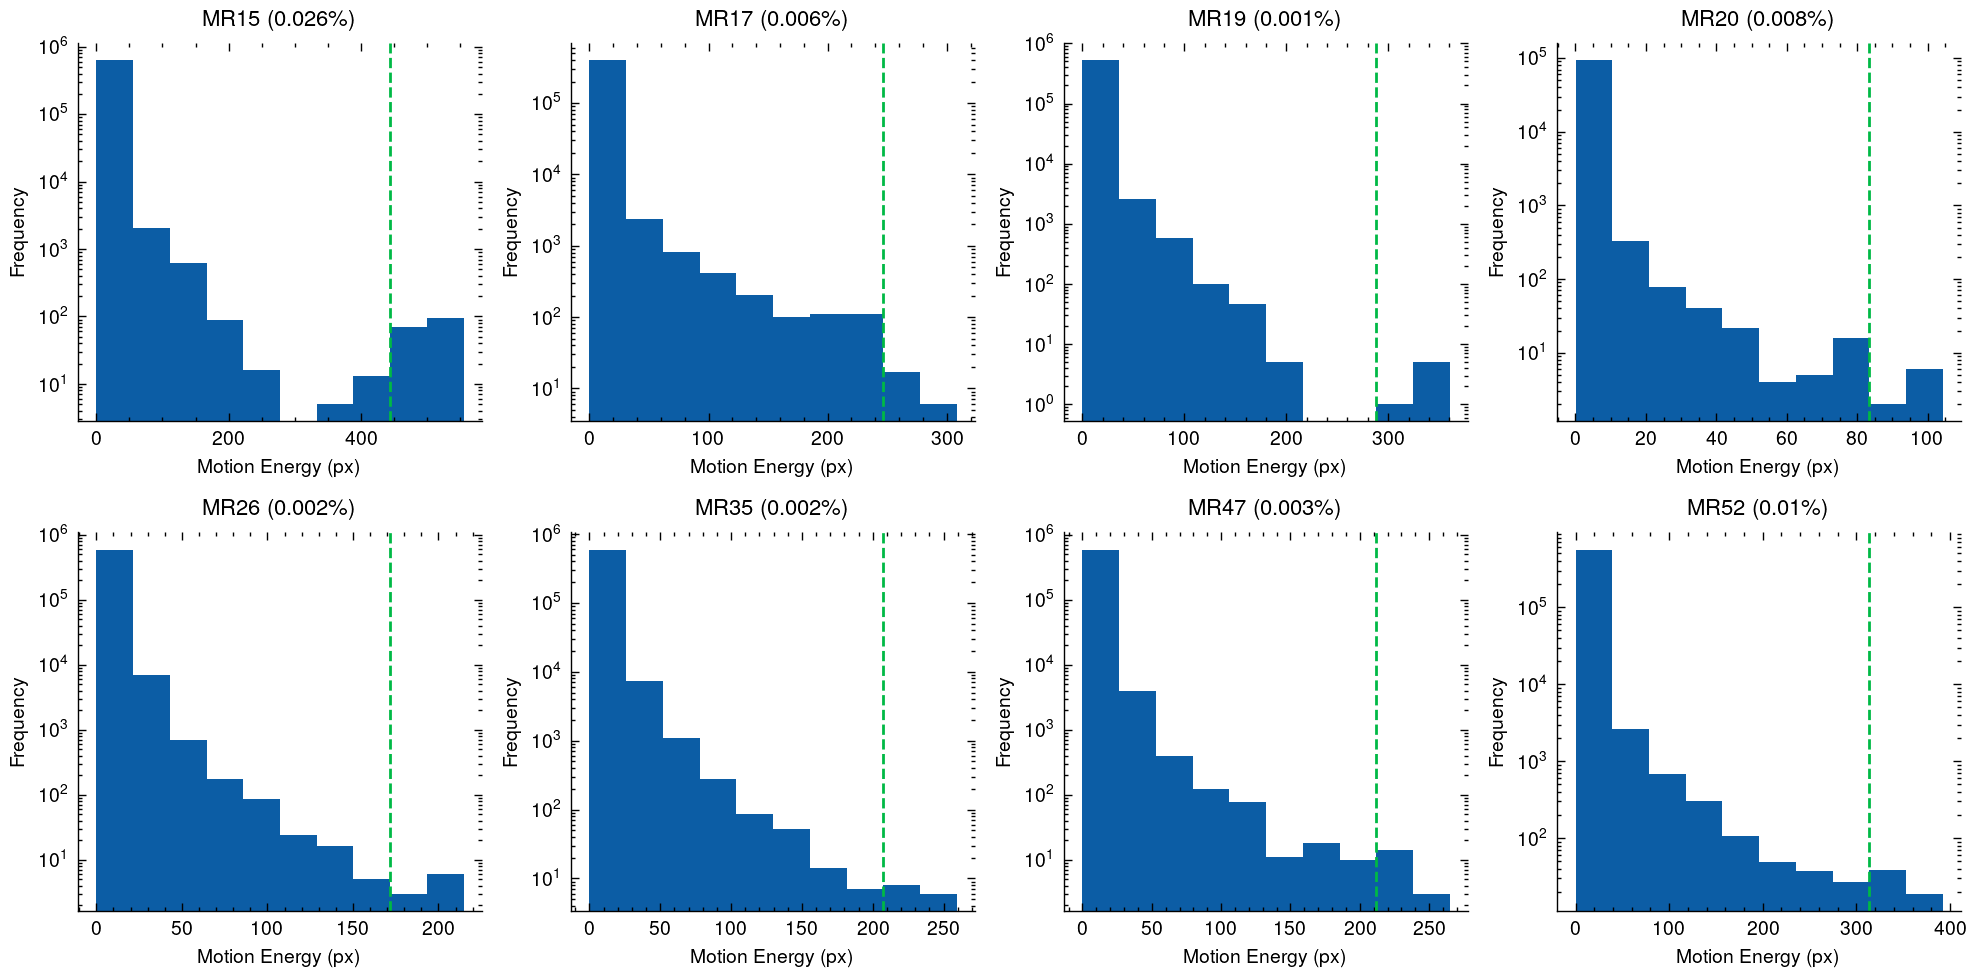

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.hist(mes_flat[i])
    ax.axvline(p_threshes[i], linestyle="--", color=colors[1])
    ax.set_yscale("log")
    ax.set_xlabel("Motion Energy (px)"); ax.set_ylabel("Frequency")
    ax.set_title(f"{subject_ids[i]} ({np.round(100*p_me_nonorm[i],3)}\%)")
    ax.title.set_fontsize(constants.SMALL_SIZE)

fig.tight_layout()
plt.show()

In [56]:
p_me_mean_nonorm = [np.mean(p_me_nonorm[:4]), np.mean(p_me_nonorm[4:])]
p_me_std_nonorm = [np.std(p_me_nonorm[:4]), np.std(p_me_nonorm[4:])]

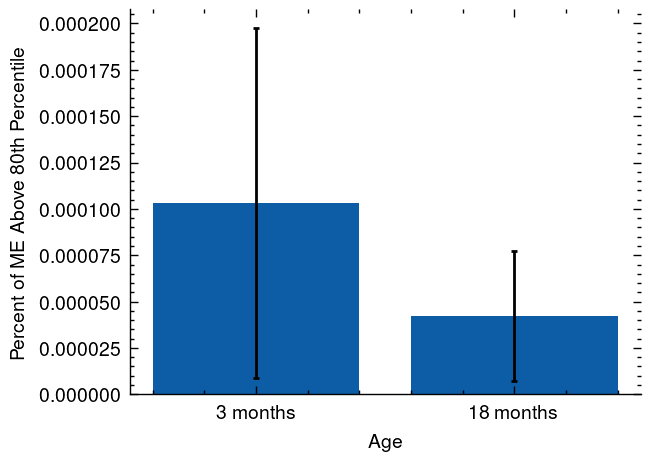

In [58]:
fig, ax = plt.subplots()
ax.bar(age_groups, p_me_mean_nonorm, yerr=p_me_std_nonorm, capsize=1)
ax.set_xlabel("Age"); ax.set_ylabel("Percent of ME Above 80th Percentile")
plt.show()

### Normalization

In [ ]:
# TODO: try coloring the bars by the percentage of the body part within that range of ME

In [63]:
mes_flat = []
for i, dlc_output in enumerate(dlc_outputs):
    print(i)
    mes_flat.append(ak.flatten(all_me(dlc_output, bodyparts, thresh=0.6, doNormBP=True)))

0
1
2
3
4
5
6
7


In [64]:
p_thresh = 0.8
p_threshes_norm = [p_thresh * (max(mes)-min(mes)) + min(mes) for mes in mes_flat]

In [65]:
p_me_norm = [p_me(mes, p_threshes_norm[i]) for i, mes in enumerate(mes_flat)]

<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
C:\Users\danci\AppData\Local\Temp\ipykernel_24296\2138547590.py:8: SyntaxWarning: invalid escape sequence '\%'
  ax.set_title(f"{subject_ids[i]} ({np.round(100*p_me_norm[i],3)}\%)")


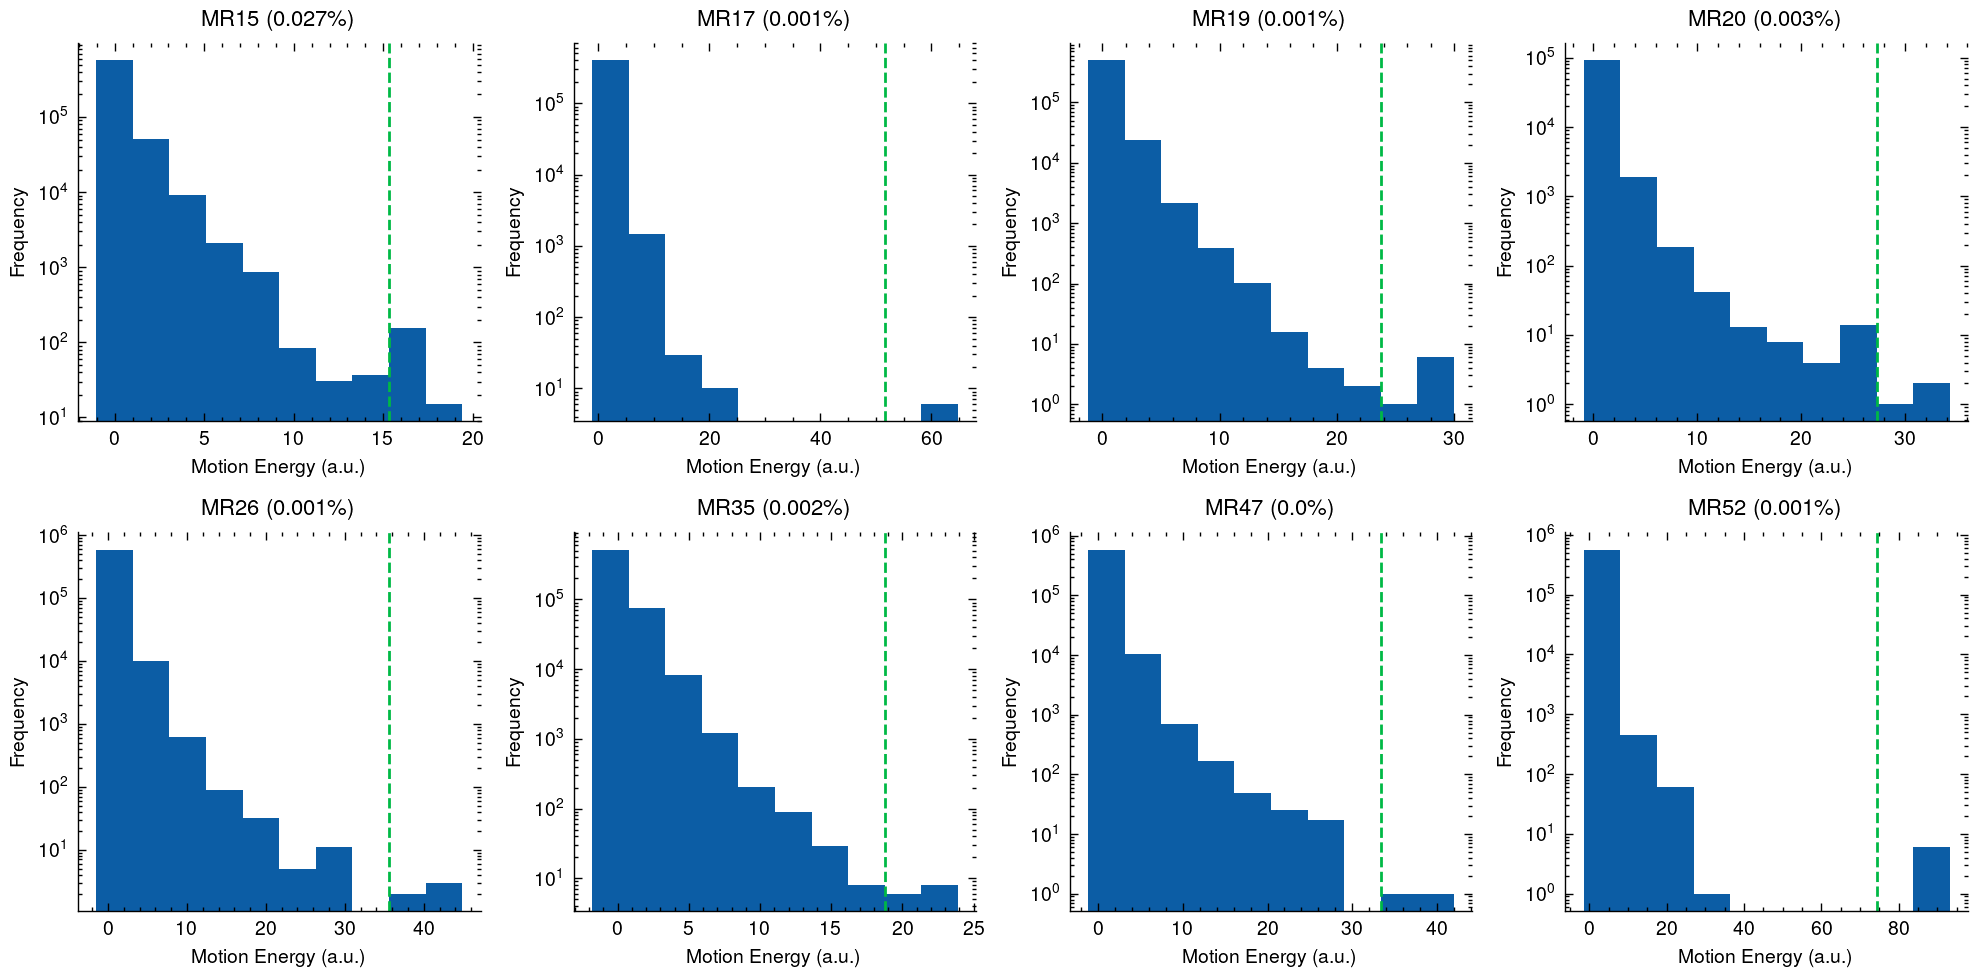

In [69]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.hist(mes_flat[i])
    ax.axvline(p_threshes_norm[i], linestyle="--", color=colors[1])
    ax.set_yscale("log")
    ax.set_xlabel("Motion Energy (a.u.)"); ax.set_ylabel("Frequency")
    ax.set_title(f"{subject_ids[i]} ({np.round(100*p_me_norm[i],3)}\%)")
    ax.title.set_fontsize(constants.SMALL_SIZE)

fig.tight_layout()
plt.show()

In [67]:
p_me_mean_norm = [np.mean(p_me_norm[:4]), np.mean(p_me_norm[4:])]
p_me_std_norm = [np.std(p_me_norm[:4]), np.std(p_me_norm[4:])]

In [ ]:
# mixed effect model, each session is a sample

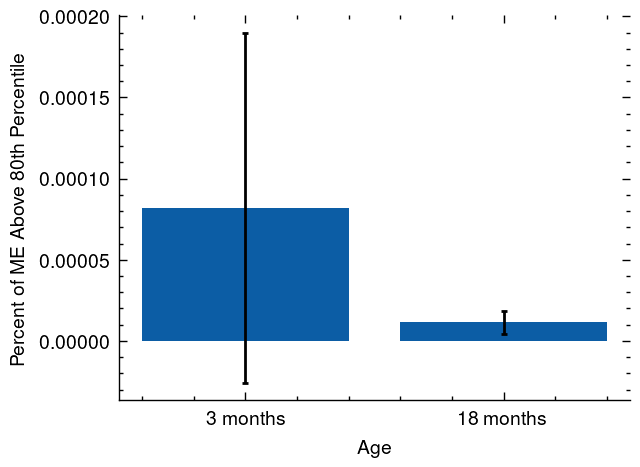

In [68]:
fig, ax = plt.subplots()
ax.bar(age_groups, p_me_mean_norm, yerr=p_me_std_norm, capsize=1)
ax.set_xlabel("Age"); ax.set_ylabel("Percent of ME Above 80th Percentile")
plt.show()